# Введение

**Проект:**  
Предсказание вероятности покупки в интернет-магазине.

**Описание:**  
Интернет-магазин стремится улучшить взаимодействие с клиентами и повысить эффективность маркетинговых кампаний. Для этого анализируется история покупок и реакции на целевые рассылки. Для дальнейшего роста необходимо лучше понимать потребности клиентов и их готовность к покупке.

**Цель проекта:**  
Создать модель для оценки вероятности покупки пользователем в течение ближайших 90 дней. Это поможет улучшить таргетинг маркетинговых предложений и повысить конверсию.

**Задачи проекта:**  

1. Изучение данных: Анализ данных о пользователях, покупках и маркетинговых взаимодействиях для выявления ключевых тенденций.  
2. Разработка признаков: Извлечение информативных признаков, таких как частота покупок, реакция на рассылки и средний чек.  
3. Создание модели: Обучение модели для предсказания вероятности покупки.  
4. Оптимизация модели: Максимизация метрики ROC AUC путем подбора гиперпараметров и улучшения модели.  

**Ожидаемые результаты:**  
Внедрение модели для персонализации предложений, что увеличит вероятность покупок и повысит продажи. Успешная реализация проекта также улучшит планирование маркетинговых акций и удовлетворенность клиентов.

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from lightgbm import LGBMClassifier
import shap
import time

In [2]:
path1 = r'H:\Мой диск\1. Практикум\Мастерская 2\filtered_data\apparel-purchases.csv'
path2 = r'J:\Мой диск\1. Практикум\Мастерская 2\filtered_data\apparel-purchases.csv'
path3 = r'J:\Мой диск\1. Практикум\Мастерская 2\filtered_data\apparel-messages.csv'
path4 = r'C:\Users\a.kuznecov\apparel-messages.csv'
path5 = r'H:\Мой диск\1. Практикум\Мастерская 2\filtered_data\apparel-target_binary.csv'
path6 = r'J:\Мой диск\1. Практикум\Мастерская 2\filtered_data\apparel-target_binary.csv'

try:
    df_purchases = pd.read_csv(path1, parse_dates=['date'])
except FileNotFoundError:
    df_purchases = pd.read_csv(path2, parse_dates=['date'])
    
try:
    df_messages = pd.read_csv(path3, parse_dates=['date', 'created_at'])
except FileNotFoundError:
    df_messages = pd.read_csv(path4, parse_dates=['date', 'created_at'])
    
try:
    df_target = pd.read_csv(path5)
except FileNotFoundError:
    df_target = pd.read_csv(path6)

In [3]:
df_purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [4]:
current_date = pd.to_datetime(df_purchases['date'].max())
current_date

Timestamp('2024-02-16 00:00:00')

In [5]:
# сколько было сделано покупок клиентом за последний месяц 
df_purchases['last_month_purchases'] = df_purchases.groupby('client_id')['date'].transform(
    lambda x: (x >= current_date - pd.DateOffset(months=1)).sum())
df_purchases.head()

,client_id,quantity,price,category_ids,date,message_id,last_month_purchases
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,0
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,0
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,0


In [6]:
# сколько было сделано покупок клиентом за последние 3 месяца
df_purchases['last_quarter_purchases'] = df_purchases.groupby('client_id')['date'].transform(
    lambda x: (x >= current_date - pd.DateOffset(months=3)).sum())
df_purchases.head()

,client_id,quantity,price,category_ids,date,message_id,last_month_purchases,last_quarter_purchases
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0,4
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0,4
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,0,0
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,0,0
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,0,0


In [7]:
# сколько было сделано покупок клиентом за последний год
df_purchases['last_year_purchases'] = df_purchases.groupby('client_id')['date'].transform(
    lambda x: (x >= current_date - pd.DateOffset(years=1)).sum())
df_purchases.head()

,client_id,quantity,price,category_ids,date,message_id,last_month_purchases,last_quarter_purchases,last_year_purchases
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0,4,6
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0,4,6
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,0,0,0
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,0,0,0
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,0,0,0


In [8]:
df_messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [9]:
df_target.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [10]:
pd.merge(df_purchases, df_target, on='client_id', how='inner').head()

,client_id,quantity,price,category_ids,date,message_id,last_month_purchases,last_quarter_purchases,last_year_purchases,target
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0,4,6,0
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,0,4,6,0
2,1515915625468169594,1,742.0,"['2', '18', '258', '1569']",2022-10-19,1515915625468169594-7180-634d2f82d8799,0,4,6,0
3,1515915625468169594,1,1050.0,"['4', '28', '124', '1602']",2023-06-30,1515915625468169594-13392-649554cd9b5ee,0,4,6,0
4,1515915625468169594,1,864.0,"['4', '28', '124', '1602']",2023-06-30,1515915625468169594-13392-649554cd9b5ee,0,4,6,0


In [11]:
pd.merge(df_purchases, df_target, on='client_id', how='inner').isna().sum()

client_id                 0
quantity                  0
price                     0
category_ids              0
date                      0
message_id                0
last_month_purchases      0
last_quarter_purchases    0
last_year_purchases       0
target                    0
dtype: int64

In [12]:
round(df_target['target'].value_counts(normalize=True) * 100, 2)

target
0    98.07
1     1.93
Name: proportion, dtype: float64

<div class="alert alert-info">
<h4> Комментарий: <a class="tocSkip"> </h4>

Мы обнаружили дисбаланс классов в данных. В дальнейшем мы планируем настроить модель, чтобы она лучше учитывала редкие случаи, используя параметр class_weight. Это поможет модели более точно предсказывать покупки, даже если таких случаев значительно меньше.
</div>

In [13]:
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   client_id               202208 non-null  int64         
 1   quantity                202208 non-null  int64         
 2   price                   202208 non-null  float64       
 3   category_ids            202208 non-null  object        
 4   date                    202208 non-null  datetime64[ns]
 5   message_id              202208 non-null  object        
 6   last_month_purchases    202208 non-null  int64         
 7   last_quarter_purchases  202208 non-null  int64         
 8   last_year_purchases     202208 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(2)
memory usage: 13.9+ MB


In [14]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


In [15]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


<div class="alert alert-info">
<h4> Комментарий: <a class="tocSkip"> </h4>

Предположительно, у клиентов нашего онлайн-магазина есть определённые предпочтения по дням для совершения покупок, например, пятница. В этот день, по окончании рабочей недели, клиенты, вероятно, отдыхая просматривают сайт и делают заказы.
</div>

In [16]:
# любимые дни недели для покупки для клиентов
df_with_day_of_week = df_purchases[['client_id', 'date']]
df_with_day_of_week['day_of_week'] = pd.to_datetime(df_with_day_of_week['date']).dt.dayofweek
df_with_day_of_week = df_with_day_of_week[['client_id', 'day_of_week']]
df_with_day_of_week['quantity'] = 1
grouped_day_of_week = df_with_day_of_week.groupby(['client_id', 'day_of_week'])['quantity'].sum().reset_index()
sorted_day_of_week = grouped_day_of_week.sort_values(by=['client_id', 'quantity'], ascending=[True, False])
fav_day_of_week = sorted_day_of_week.drop_duplicates(subset='client_id', keep='first')
fav_day_of_week.head()

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11268\635310363.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_day_of_week['day_of_week'] = pd.to_datetime(df_with_day_of_week['date']).dt.dayofweek


,client_id,day_of_week,quantity
0,1515915625468060902,4,7
1,1515915625468061003,2,7
2,1515915625468061099,1,1
3,1515915625468061100,5,2
4,1515915625468061170,2,12


In [65]:
fav_day_of_week.head()

,client_id,day_of_week,quantity
0,1515915625468060902,4,7
1,1515915625468061003,2,7
2,1515915625468061099,1,1
3,1515915625468061100,5,2
4,1515915625468061170,2,12


In [18]:
df_purchases['total_spent'] = df_purchases['quantity'] * df_purchases['price']
df_purchases['purchase_date'] = df_purchases['date']
df_purchases = df_purchases.drop(['quantity', 'price', 'date'], axis=1)
df_purchases.head()

,client_id,category_ids,message_id,last_month_purchases,last_quarter_purchases,last_year_purchases,total_spent,purchase_date
0,1515915625468169594,"['4', '28', '57', '431']",1515915625468169594-4301-627b661e9736d,0,4,6,1999.0,2022-05-16
1,1515915625468169594,"['4', '28', '57', '431']",1515915625468169594-4301-627b661e9736d,0,4,6,2499.0,2022-05-16
2,1515915625471138230,"['4', '28', '57', '431']",1515915625471138230-4437-6282242f27843,0,0,0,6499.0,2022-05-16
3,1515915625471138230,"['4', '28', '244', '432']",1515915625471138230-4437-6282242f27843,0,0,0,4999.0,2022-05-16
4,1515915625471138230,"['4', '28', '49', '413']",1515915625471138230-4437-6282242f27843,0,0,0,4999.0,2022-05-16


<div class="alert alert-info">
<h4> Комментарий: <a class="tocSkip"> </h4>

Предполагается, что у клиентов нашего онлайн-магазина могут быть предпочтения по месяцам для совершения покупок, связанные с определёнными праздниками. Например, Новый год или 8 марта могут быть периодами, когда клиенты чаще делают заказы.
</div>

In [19]:
# любимые месяцы для покупки для клиентов
favorite_month_for_purchase = df_purchases[['client_id', 'purchase_date']].copy()
favorite_month_for_purchase['month'] = favorite_month_for_purchase['purchase_date'].dt.month
favorite_month_for_purchase['quantity'] = 1
favorite_month_for_purchase = favorite_month_for_purchase[['client_id', 'month', 'quantity']]
favorite_month_for_purchase = favorite_month_for_purchase.groupby(['client_id', 'month'])['quantity'].sum().reset_index()
favorite_month_for_purchase = favorite_month_for_purchase.sort_values(by=[
    'client_id', 'quantity'], ascending=[True, False])
favorite_month_for_purchase = favorite_month_for_purchase.drop_duplicates(subset='client_id', keep='first')
favorite_month_for_purchase.drop(columns='quantity', axis=1, inplace=True)
favorite_month_for_purchase.head()

,client_id,month
0,1515915625468060902,5
1,1515915625468061003,1
2,1515915625468061099,5
3,1515915625468061100,2
4,1515915625468061170,3


<div class="alert alert-info">
<h4> Комментарий: <a class="tocSkip"> </h4>

Предполагается, что у клиентов нашего онлайн-магазина могут быть предпочтения по категориям товаров при совершении покупок. Это может означать, что определённые категории товаров пользуются повышенным спросом.
</div>

In [20]:
# любимые категории для покупки для клиентов
category_ids = df_purchases[['client_id', 'category_ids']].copy()
category_ids['category_ids'] = category_ids['category_ids'].str.strip('[]').str.strip("'").str.replace("', '", ",")
category_ids[['category_id_1', 
              'category_id_2',
              'category_id_3',
              'category_id_4']] = category_ids['category_ids'].str.split(',', n=3, expand=True)
category_ids.drop('category_ids', axis=1, inplace=True)
category_ids.head()

,client_id,category_id_1,category_id_2,category_id_3,category_id_4
0,1515915625468169594,4,28,57,431
1,1515915625468169594,4,28,57,431
2,1515915625471138230,4,28,57,431
3,1515915625471138230,4,28,244,432
4,1515915625471138230,4,28,49,413


In [21]:
count_table = category_ids.groupby(['client_id', 'category_id_1']).size().unstack(fill_value=0).reset_index()
count_table.head()

category_id_1,client_id,,1,2,3,4,5,5562,5963,6060,None
0,1515915625468060902,0,0,0,0,7,0,0,0,0,0
1,1515915625468061003,0,0,0,0,7,0,0,0,0,0
2,1515915625468061099,0,0,0,0,1,0,0,0,0,0
3,1515915625468061100,0,0,0,0,2,0,0,0,0,0
4,1515915625468061170,2,0,2,0,15,0,0,0,0,0


In [22]:
count_table_cat2 = category_ids.groupby(['client_id', 'category_id_2']).size().unstack(fill_value=0).reset_index()
count_table_cat2.head()

category_id_2,client_id,10,12,14,17,18,1822,22,27,28,...,5633,5634,5683,5697,5837,5959,6057,6058,6059,8
0,1515915625468060902,0,0,0,0,0,0,0,3,4,...,0,0,0,0,0,0,0,0,0,0
1,1515915625468061003,0,0,0,0,0,0,0,0,7,...,0,0,0,0,0,0,0,0,0,0
2,1515915625468061099,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1515915625468061100,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
4,1515915625468061170,0,0,0,0,2,0,0,0,15,...,0,0,0,0,0,0,0,0,0,0


In [23]:
count_table_cat3 = category_ids.groupby(['client_id', 'category_id_3']).size().unstack(fill_value=0).reset_index()
count_table_cat3.head()

category_id_3,client_id,104,105,107,108,1097,123,124,137,138,...,6244,6245,6265,6266,63,6309,79,83,84,989
0,1515915625468060902,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1515915625468061003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1515915625468061099,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1515915625468061100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1515915625468061170,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
count_table_cat4 = category_ids.groupby(['client_id', 'category_id_4']).size().unstack(fill_value=0).reset_index()
count_table_cat4.head()

category_id_4,client_id,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,986,987,988,989,991,992,993,994,995,999
0,1515915625468060902,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1515915625468061003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1515915625468061099,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1515915625468061100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1515915625468061170,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
unpivoted_table = count_table.melt(id_vars='client_id', var_name='category_id_1', value_name='count')
sorted_table = unpivoted_table.sort_values(by=['client_id', 'count'], ascending=[False, False])
unique_table = sorted_table.drop_duplicates(subset='client_id', keep='first')
unique_table = unique_table[['client_id', 'category_id_1']]
unique_table.head()

,client_id,category_id_1
249244,1515915626010443624,4
149545,1515915626010443527,2
249242,1515915626010439406,4
249241,1515915626010266132,4
149542,1515915626010261344,2


In [26]:
unpivoted_table_cat2 = count_table_cat2.melt(id_vars='client_id', var_name='category_id_2', value_name='count')
sorted_table_cat2 = unpivoted_table_cat2.sort_values(by=['client_id', 'count'], ascending=[False, False])
unique_table_cat2 = sorted_table_cat2.drop_duplicates(subset='client_id', keep='first')
unique_table_cat2 = unique_table_cat2[['client_id', 'category_id_2']]
unique_table_cat2.head()

,client_id,category_id_2
448631,1515915626010443624,28
249238,1515915626010443527,18
398781,1515915626010439406,27
398780,1515915626010266132,27
249235,1515915626010261344,18


In [27]:
unpivoted_table_cat3 = count_table_cat3.melt(id_vars='client_id', var_name='category_id_3', value_name='count')
sorted_table_cat3 = unpivoted_table_cat3.sort_values(by=['client_id', 'count'], ascending=[False, False])
unique_table_cat3 = sorted_table_cat3.drop_duplicates(subset='client_id', keep='first')
unique_table_cat3 = unique_table_cat3[['client_id', 'category_id_3']]
unique_table_cat3.head()

,client_id,category_id_3
13957439,1515915626010443624,62
2641942,1515915626010443527,274
2143461,1515915626010439406,233
2741636,1515915626010266132,278
1794523,1515915626010261344,212


In [28]:
unpivoted_table_cat4 = count_table_cat4.melt(id_vars='client_id', var_name='category_id_4', value_name='count')
sorted_table_cat4 = unpivoted_table_cat4.sort_values(by=['client_id', 'count'], ascending=[False, False])
unique_table_cat4 = sorted_table_cat4.drop_duplicates(subset='client_id', keep='first')
unique_table_cat4 = unique_table_cat4[['client_id', 'category_id_4']]
unique_table_cat4.head()

,client_id,category_id_4
34123011,1515915626010443624,656
20294734,1515915626010443527,446
20941379,1515915626010439406,462
21289572,1515915626010266132,470
36460881,1515915626010261344,726


In [29]:
df_purchases.columns

Index(['client_id', 'category_ids', 'message_id', 'last_month_purchases',
       'last_quarter_purchases', 'last_year_purchases', 'total_spent',
       'purchase_date'],
      dtype='object')

In [30]:
df_messages['event_date'] = df_messages['date']
df_messages = df_messages.drop(['date', 'created_at'], axis=1)
df_messages.head()                               

,bulk_campaign_id,client_id,message_id,event,channel,event_date
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19


In [31]:
df_for_pivot = df_messages[['client_id', 'event']].copy()
df_for_pivot['quantity'] = 1
df_for_pivot
messages_pivot = pd.pivot_table(df_for_pivot, 
                                values='quantity', 
                                index='client_id', 
                                columns='event', 
                                aggfunc='sum').reset_index()
messages_pivot = messages_pivot.fillna(0)
messages_pivot.head()

event,client_id,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe
0,1515915625468060902,10.0,0.0,0.0,0.0,0.0,35.0,5.0,126.0,0.0,0.0,1.0
1,1515915625468061003,6.0,0.0,0.0,0.0,0.0,5.0,1.0,154.0,0.0,0.0,0.0
2,1515915625468061099,8.0,0.0,0.0,2.0,0.0,51.0,0.0,215.0,0.0,0.0,0.0
3,1515915625468061100,1.0,0.0,0.0,1.0,0.0,163.0,1.0,267.0,1.0,0.0,0.0
4,1515915625468061170,16.0,0.0,0.0,0.0,0.0,31.0,3.0,243.0,0.0,0.0,0.0


In [32]:
purchase_summary = df_purchases.groupby('client_id').agg({
    'total_spent' : ['sum', 'mean', 'count'],
    'purchase_date' : ['max', 'min'],
    'last_month_purchases' : 'max',
    'last_quarter_purchases' : 'max',
    'last_year_purchases' : 'max'
}).reset_index()
purchase_summary.columns = ['client_id', 
                            'total_spent_sum', 
                            'total_spent_mean', 
                            'purchase_count', 
                            'last_purchase_date',
                            'first_purchase_date',
                            'last_month_purchases',
                            'last_quarter_purchases',
                            'last_year_purchases'
                           ]
purchase_summary.head()

,client_id,total_spent_sum,total_spent_mean,purchase_count,last_purchase_date,first_purchase_date,last_month_purchases,last_quarter_purchases,last_year_purchases
0,1515915625468060902,6993.0,999.000000,7,2022-05-27,2022-05-27,0,0,0
1,1515915625468061003,16235.0,2319.285714,7,2023-01-04,2023-01-04,0,0,0
2,1515915625468061099,299.0,299.000000,1,2022-05-17,2022-05-17,0,0,0
3,1515915625468061100,2098.0,1049.000000,2,2024-02-10,2024-02-10,2,2,2
4,1515915625468061170,33601.0,1768.473684,19,2023-06-17,2023-03-26,0,0,19


In [33]:
message_summary = df_messages.groupby('client_id').agg({
    'message_id' : 'count',
    'event_date' : ['max', 'min']
}).reset_index()
message_summary.columns = ['client_id', 'message_count', 'last_message_date', 'first_message_date']
message_summary.head()

,client_id,message_count,last_message_date,first_message_date
0,1515915625468060902,177,2024-01-19,2022-05-19
1,1515915625468061003,166,2024-02-13,2022-05-20
2,1515915625468061099,276,2024-02-13,2022-05-19
3,1515915625468061100,434,2024-02-15,2022-05-19
4,1515915625468061170,293,2024-02-15,2022-05-25


In [34]:
df = pd.merge(purchase_summary, message_summary, on='client_id', how='left')
df = pd.merge(df, df_target, on='client_id', how='left')
df = pd.merge(df, messages_pivot, on='client_id', how='left')
df = pd.merge(df, unique_table, on='client_id', how='left')
df = pd.merge(df, unique_table_cat2, on='client_id', how='left') 
df = pd.merge(df, favorite_month_for_purchase, on='client_id', how='left')
df = pd.merge(df, unique_table_cat3, on='client_id', how='left') 
df = pd.merge(df, unique_table_cat4, on='client_id', how='left')
df = pd.merge(df, fav_day_of_week, on='client_id', how='left')
df.head()

,client_id,total_spent_sum,total_spent_mean,purchase_count,last_purchase_date,first_purchase_date,last_month_purchases,last_quarter_purchases,last_year_purchases,message_count,...,soft_bounce,subscribe,unsubscribe,category_id_1,category_id_2,month,category_id_3,category_id_4,day_of_week,quantity
0,1515915625468060902,6993.0,999.000000,7,2022-05-27,2022-05-27,0,0,0,177.0,...,0.0,0.0,1.0,4,28,5,176,420,4,7
1,1515915625468061003,16235.0,2319.285714,7,2023-01-04,2023-01-04,0,0,0,166.0,...,0.0,0.0,0.0,4,28,1,249,615,2,7
2,1515915625468061099,299.0,299.000000,1,2022-05-17,2022-05-17,0,0,0,276.0,...,0.0,0.0,0.0,4,28,5,290,424,1,1
3,1515915625468061100,2098.0,1049.000000,2,2024-02-10,2024-02-10,2,2,2,434.0,...,1.0,0.0,0.0,4,27,2,1828,5717,5,2
4,1515915625468061170,33601.0,1768.473684,19,2023-06-17,2023-03-26,0,0,19,293.0,...,0.0,0.0,0.0,4,28,3,260,420,2,12


In [35]:
# наступит или нет любимый месяц клиента для покупок в ближайшие 90 дней
date_plus_90 = current_date + pd.Timedelta(days=90)
date_range_90d = pd.date_range(start=current_date, end=date_plus_90)
df['fav_month_in_next_90d'] = df['month'].apply(
    lambda x: 1 if x in date_range_90d.month else 0) 
df.head()

,client_id,total_spent_sum,total_spent_mean,purchase_count,last_purchase_date,first_purchase_date,last_month_purchases,last_quarter_purchases,last_year_purchases,message_count,...,subscribe,unsubscribe,category_id_1,category_id_2,month,category_id_3,category_id_4,day_of_week,quantity,fav_month_in_next_90d
0,1515915625468060902,6993.0,999.000000,7,2022-05-27,2022-05-27,0,0,0,177.0,...,0.0,1.0,4,28,5,176,420,4,7,1
1,1515915625468061003,16235.0,2319.285714,7,2023-01-04,2023-01-04,0,0,0,166.0,...,0.0,0.0,4,28,1,249,615,2,7,0
2,1515915625468061099,299.0,299.000000,1,2022-05-17,2022-05-17,0,0,0,276.0,...,0.0,0.0,4,28,5,290,424,1,1,1
3,1515915625468061100,2098.0,1049.000000,2,2024-02-10,2024-02-10,2,2,2,434.0,...,0.0,0.0,4,27,2,1828,5717,5,2,1
4,1515915625468061170,33601.0,1768.473684,19,2023-06-17,2023-03-26,0,0,19,293.0,...,0.0,0.0,4,28,3,260,420,2,12,1


In [36]:
# был или нет любимый месяц клиента для покупок в последние 90 дней
date_minus_90 = current_date - pd.Timedelta(days=90)
date_range_90d_2 = pd.date_range(start=date_minus_90, end=current_date)
df['fav_month_in_last_90d'] = df['month'].apply(
    lambda x: 1 if x in date_range_90d_2.month else 0) 
df.head()

,client_id,total_spent_sum,total_spent_mean,purchase_count,last_purchase_date,first_purchase_date,last_month_purchases,last_quarter_purchases,last_year_purchases,message_count,...,unsubscribe,category_id_1,category_id_2,month,category_id_3,category_id_4,day_of_week,quantity,fav_month_in_next_90d,fav_month_in_last_90d
0,1515915625468060902,6993.0,999.000000,7,2022-05-27,2022-05-27,0,0,0,177.0,...,1.0,4,28,5,176,420,4,7,1,0
1,1515915625468061003,16235.0,2319.285714,7,2023-01-04,2023-01-04,0,0,0,166.0,...,0.0,4,28,1,249,615,2,7,0,1
2,1515915625468061099,299.0,299.000000,1,2022-05-17,2022-05-17,0,0,0,276.0,...,0.0,4,28,5,290,424,1,1,1,0
3,1515915625468061100,2098.0,1049.000000,2,2024-02-10,2024-02-10,2,2,2,434.0,...,0.0,4,27,2,1828,5717,5,2,1,1
4,1515915625468061170,33601.0,1768.473684,19,2023-06-17,2023-03-26,0,0,19,293.0,...,0.0,4,28,3,260,420,2,12,1,0


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   client_id               49849 non-null  int64         
 1   total_spent_sum         49849 non-null  float64       
 2   total_spent_mean        49849 non-null  float64       
 3   purchase_count          49849 non-null  int64         
 4   last_purchase_date      49849 non-null  datetime64[ns]
 5   first_purchase_date     49849 non-null  datetime64[ns]
 6   last_month_purchases    49849 non-null  int64         
 7   last_quarter_purchases  49849 non-null  int64         
 8   last_year_purchases     49849 non-null  int64         
 9   message_count           41982 non-null  float64       
 10  last_message_date       41982 non-null  datetime64[ns]
 11  first_message_date      41982 non-null  datetime64[ns]
 12  target                  49849 non-null  int64 

In [38]:
df.isna().sum()

client_id                    0
total_spent_sum              0
total_spent_mean             0
purchase_count               0
last_purchase_date           0
first_purchase_date          0
last_month_purchases         0
last_quarter_purchases       0
last_year_purchases          0
message_count             7867
last_message_date         7867
first_message_date        7867
target                       0
click                     7867
close                     7867
complain                  7867
hard_bounce               7867
hbq_spam                  7867
open                      7867
purchase                  7867
send                      7867
soft_bounce               7867
subscribe                 7867
unsubscribe               7867
category_id_1                0
category_id_2                1
month                        0
category_id_3                1
category_id_4              107
day_of_week                  0
quantity                     0
fav_month_in_next_90d        0
fav_mont

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   client_id               49849 non-null  int64         
 1   total_spent_sum         49849 non-null  float64       
 2   total_spent_mean        49849 non-null  float64       
 3   purchase_count          49849 non-null  int64         
 4   last_purchase_date      49849 non-null  datetime64[ns]
 5   first_purchase_date     49849 non-null  datetime64[ns]
 6   last_month_purchases    49849 non-null  int64         
 7   last_quarter_purchases  49849 non-null  int64         
 8   last_year_purchases     49849 non-null  int64         
 9   message_count           41982 non-null  float64       
 10  last_message_date       41982 non-null  datetime64[ns]
 11  first_message_date      41982 non-null  datetime64[ns]
 12  target                  49849 non-null  int64 

In [40]:
df['days_since_last_purchase'] = (pd.Timestamp.now() - df['last_purchase_date']).dt.days
df['days_since_first_purchase'] = (pd.Timestamp.now() - df['first_purchase_date']).dt.days
df['days_since_last_message'] = (pd.Timestamp.now() - df['last_message_date']).dt.days
df['days_since_first_message'] = (pd.Timestamp.now() - df['first_message_date']).dt.days
df['avg_days_between_purchases'] = df['avg_days_between_purchases'] = (
    (df['last_purchase_date'] - df['first_purchase_date']).dt.days / (df['purchase_count'] - 1) + 1
)
df.head()

,client_id,total_spent_sum,total_spent_mean,purchase_count,last_purchase_date,first_purchase_date,last_month_purchases,last_quarter_purchases,last_year_purchases,message_count,...,category_id_4,day_of_week,quantity,fav_month_in_next_90d,fav_month_in_last_90d,days_since_last_purchase,days_since_first_purchase,days_since_last_message,days_since_first_message,avg_days_between_purchases
0,1515915625468060902,6993.0,999.000000,7,2022-05-27,2022-05-27,0,0,0,177.0,...,420,4,7,1,0,828,828,226.0,836.0,1.000000
1,1515915625468061003,16235.0,2319.285714,7,2023-01-04,2023-01-04,0,0,0,166.0,...,615,2,7,0,1,606,606,201.0,835.0,1.000000
2,1515915625468061099,299.0,299.000000,1,2022-05-17,2022-05-17,0,0,0,276.0,...,424,1,1,1,0,838,838,201.0,836.0,NaN
3,1515915625468061100,2098.0,1049.000000,2,2024-02-10,2024-02-10,2,2,2,434.0,...,5717,5,2,1,1,204,204,199.0,836.0,1.000000
4,1515915625468061170,33601.0,1768.473684,19,2023-06-17,2023-03-26,0,0,19,293.0,...,420,2,12,1,0,442,525,199.0,830.0,5.611111


In [41]:
df.isna().sum()

client_id                         0
total_spent_sum                   0
total_spent_mean                  0
purchase_count                    0
last_purchase_date                0
first_purchase_date               0
last_month_purchases              0
last_quarter_purchases            0
last_year_purchases               0
message_count                  7867
last_message_date              7867
first_message_date             7867
target                            0
click                          7867
close                          7867
complain                       7867
hard_bounce                    7867
hbq_spam                       7867
open                           7867
purchase                       7867
send                           7867
soft_bounce                    7867
subscribe                      7867
unsubscribe                    7867
category_id_1                     0
category_id_2                     1
month                             0
category_id_3               

In [42]:
df.fillna(0, inplace=True)
df.isna().sum()

client_id                     0
total_spent_sum               0
total_spent_mean              0
purchase_count                0
last_purchase_date            0
first_purchase_date           0
last_month_purchases          0
last_quarter_purchases        0
last_year_purchases           0
message_count                 0
last_message_date             0
first_message_date            0
target                        0
click                         0
close                         0
complain                      0
hard_bounce                   0
hbq_spam                      0
open                          0
purchase                      0
send                          0
soft_bounce                   0
subscribe                     0
unsubscribe                   0
category_id_1                 0
category_id_2                 0
month                         0
category_id_3                 0
category_id_4                 0
day_of_week                   0
quantity                      0
fav_mont

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   client_id                   49849 non-null  int64         
 1   total_spent_sum             49849 non-null  float64       
 2   total_spent_mean            49849 non-null  float64       
 3   purchase_count              49849 non-null  int64         
 4   last_purchase_date          49849 non-null  datetime64[ns]
 5   first_purchase_date         49849 non-null  datetime64[ns]
 6   last_month_purchases        49849 non-null  int64         
 7   last_quarter_purchases      49849 non-null  int64         
 8   last_year_purchases         49849 non-null  int64         
 9   message_count               49849 non-null  float64       
 10  last_message_date           49849 non-null  object        
 11  first_message_date          49849 non-null  object    

In [44]:
df[['category_id_1', 
    'category_id_2', 
    'category_id_3', 
    'category_id_4']] = df[['category_id_1', 
                            'category_id_2', 
                            'category_id_3',
                            'category_id_4']].apply(pd.to_numeric, errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   client_id                   49849 non-null  int64         
 1   total_spent_sum             49849 non-null  float64       
 2   total_spent_mean            49849 non-null  float64       
 3   purchase_count              49849 non-null  int64         
 4   last_purchase_date          49849 non-null  datetime64[ns]
 5   first_purchase_date         49849 non-null  datetime64[ns]
 6   last_month_purchases        49849 non-null  int64         
 7   last_quarter_purchases      49849 non-null  int64         
 8   last_year_purchases         49849 non-null  int64         
 9   message_count               49849 non-null  float64       
 10  last_message_date           49849 non-null  object        
 11  first_message_date          49849 non-null  object    

In [45]:
df.columns

Index(['client_id', 'total_spent_sum', 'total_spent_mean', 'purchase_count',
       'last_purchase_date', 'first_purchase_date', 'last_month_purchases',
       'last_quarter_purchases', 'last_year_purchases', 'message_count',
       'last_message_date', 'first_message_date', 'target', 'click', 'close',
       'complain', 'hard_bounce', 'hbq_spam', 'open', 'purchase', 'send',
       'soft_bounce', 'subscribe', 'unsubscribe', 'category_id_1',
       'category_id_2', 'month', 'category_id_3', 'category_id_4',
       'day_of_week', 'quantity', 'fav_month_in_next_90d',
       'fav_month_in_last_90d', 'days_since_last_purchase',
       'days_since_first_purchase', 'days_since_last_message',
       'days_since_first_message', 'avg_days_between_purchases'],
      dtype='object')

In [46]:
X = df.drop([
    'client_id', 
    'last_purchase_date', 
    'first_purchase_date', 
    'last_message_date', 
    'first_message_date', 
    'target',
    'fav_month_in_next_90d',
    'category_id_1',
    'complain',
    'hbq_spam',
    'subscribe',
    'close'
], axis=1)
y = df['target']

In [47]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   total_spent_sum             49849 non-null  float64
 1   total_spent_mean            49849 non-null  float64
 2   purchase_count              49849 non-null  int64  
 3   last_month_purchases        49849 non-null  int64  
 4   last_quarter_purchases      49849 non-null  int64  
 5   last_year_purchases         49849 non-null  int64  
 6   message_count               49849 non-null  float64
 7   click                       49849 non-null  float64
 8   hard_bounce                 49849 non-null  float64
 9   open                        49849 non-null  float64
 10  purchase                    49849 non-null  float64
 11  send                        49849 non-null  float64
 12  soft_bounce                 49849 non-null  float64
 13  unsubscribe                 498

In [50]:
ohe_columns = X.select_dtypes(include=['object']).columns
num_columns = X.select_dtypes(exclude=['object']).columns
ohe_columns, num_columns

(Index([], dtype='object'),
 Index(['total_spent_sum', 'total_spent_mean', 'purchase_count',
        'last_month_purchases', 'last_quarter_purchases', 'last_year_purchases',
        'message_count', 'click', 'hard_bounce', 'open', 'purchase', 'send',
        'soft_bounce', 'unsubscribe', 'category_id_2', 'month', 'category_id_3',
        'category_id_4', 'day_of_week', 'quantity', 'fav_month_in_last_90d',
        'days_since_last_purchase', 'days_since_first_purchase',
        'days_since_last_message', 'days_since_first_message',
        'avg_days_between_purchases'],
       dtype='object'))

In [51]:
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(drop='first'), ohe_columns),
        ('num', StandardScaler(), num_columns)
    ])

In [52]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [53]:
param_grid = [{
    'classifier' : [RandomForestClassifier(random_state=42)],
    'classifier__class_weight' : ['balanced'],
    'classifier__n_estimators' : [200, 500],
    'classifier__max_depth' : [10, 50],
    'classifier__min_samples_split' : [5, 12],
    },
    {
    'classifier' : [LGBMClassifier(random_state=42)],
    'classifier__scale_pos_weight' : [1, 5, 10],
    'classifier__n_estimators' : [100, 300],
    'classifier__max_depth' : [10, 50],
    'classifier__learning_rate' : [0.01, 0.1],
    'classifier__num_leaves' : [5, 12]
    }
]

In [54]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((39879, 26), (9970, 26), (39879,), (9970,))

In [56]:
start_grid_searh = time.time()
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
[LightGBM] [Info] Number of positive: 740, number of negative: 39139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3444
[LightGBM] [Info] Number of data points in the train set: 39879, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968225
[LightGBM] [Info] Start training from score -3.968225


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         Index([], dtype='object')),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         Index(['total_spent_sum', 'total_spent_mean', 'purchase_count',
       'last_month_purchases', 'last_quarter_purchases', 'last_year_purchases',
       'message_count', 'click', 'hard_bounce', 'ope...
                          'classifier__max_depth': [10, 50],
                          'classifier__min_samples_split': [5, 12],
                          'classifier__n_estimators': [200, 500]},
                         {'classifier': [LGBMClassifier(random_state=42)],
                          'classifier__learning_rate': [0.01, 0.1],
                          'classifier__max_depth': [10, 50],
                          'classifier__n_estimators': [100, 300],
                          'classifier__num_leaves': [5, 12],
                          'classifier__scale_pos_weight': [1, 5, 10]}],
             scoring='roc_auc', verbose=2)

In [57]:
print('Лучшие параметры:', grid_search.best_params_ )

Лучшие параметры: {'classifier': LGBMClassifier(random_state=42), 'classifier__learning_rate': 0.01, 'classifier__max_depth': 50, 'classifier__n_estimators': 300, 'classifier__num_leaves': 12, 'classifier__scale_pos_weight': 10}


In [58]:
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

In [59]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC: {roc_auc:.4f}')

ROC AUC: 0.7512


In [60]:
threshold = 0.5
y_pred = np.where(y_pred_proba >= threshold, 1, 0)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      9749
           1       0.18      0.09      0.12       221

    accuracy                           0.97      9970
   macro avg       0.58      0.54      0.55      9970
weighted avg       0.96      0.97      0.97      9970



C:\Anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


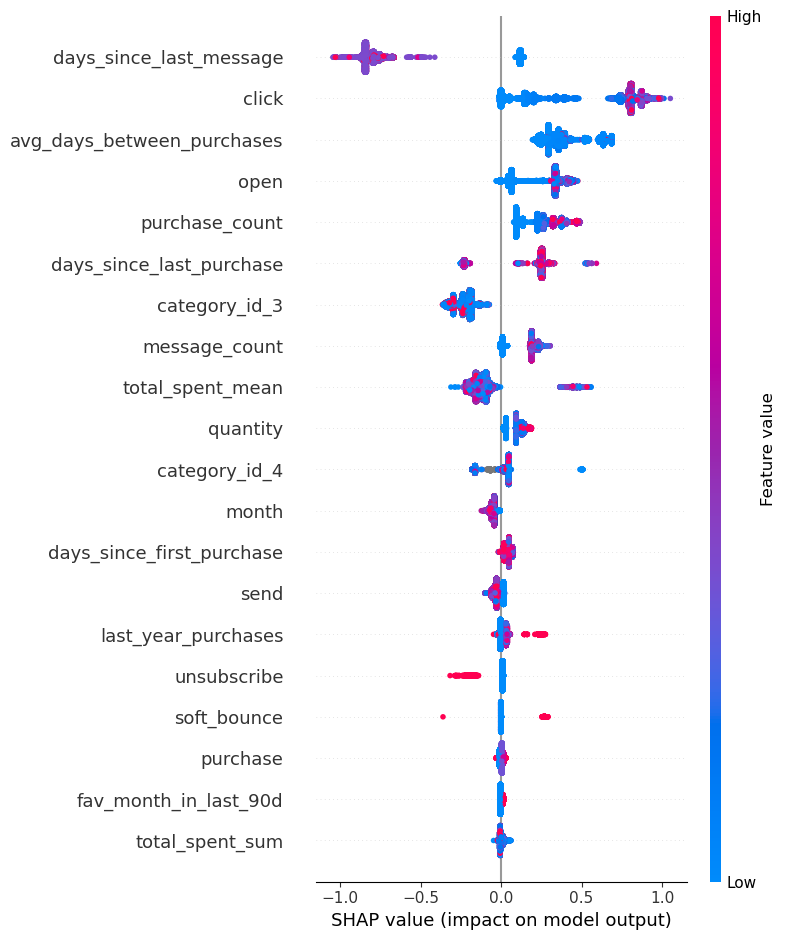

In [61]:
model = best_model.named_steps['classifier']
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [62]:
full_time_grid_search = (time.time() - start_grid_searh) / 60
full_time_grid_search

2.4411715149879454

<div class="alert alert-info">
<h4> Комментарий: <a class="tocSkip"> </h4>

В ходе выполнения проекта по предсказанию вероятности покупки в интернет-магазине были выполнены следующие ключевые шаги:

**Анализ данных:**   
Были тщательно изучены данные о покупках, взаимодействиях с маркетинговыми сообщениями и целевые данные. Были выявлены ключевые тенденции, такие как частота покупок, и предпочтения клиентов по дням и месяцам.

**Разработка признаков:**  
На основе изученных данных были разработаны информативные признаки. Было вычислено количество покупок клиентов за последний месяц, квартал и год, а также определены любимые дни недели и месяцы для покупок. Были также созданы признаки, отражающие взаимодействие клиентов с маркетинговыми сообщениями.

**Создание и оптимизация модели:**  
Была разработана модель для предсказания вероятности покупки с использованием RandomForestClassifier и LGBMClassifier. Параметры моделей были оптимизированы с помощью GridSearchCV, что позволило улучшить их производительность.

**Результаты:**

ROC AUC: 0.7512  
Precision для класса 0: 0.98  
Recall для класса 0: 0.99  
F1-score для класса 0: 0.99  
Precision для класса 1: 0.18  
Recall для класса 1: 0.09  
F1-score для класса 1: 0.12  
Macro Average Precision: 0.58  
Macro Average Recall: 0.54  
Macro Average F1-score: 0.55  
Weighted Average Precision: 0.96  
Weighted Average Recall: 0.97  
Weighted Average F1-score: 0.97  
    
Как видно из представленных результатов, модель демонстрирует высокие значения precision и recall для отрицательного класса (отсутствие покупки), но имеет низкие значения для положительного класса (покупка), что указывает на проблемы с определением положительных случаев.

**Для улучшения модели предполагается опробовать в дальнейшем следующие действия:**


**Балансировка классов:**

Опробовать методы oversampling для увеличения числа положительных примеров (например, SMOTE) или undersampling для уменьшения числа отрицательных примеров.
Применить взвешивание классов при обучении модели, чтобы увеличить штраф за ошибки в предсказании положительных случаев.
Провести более тщательную настройку гиперпараметров моделей, чтобы улучшить их способность справляться с дисбалансом классов.

**Анализ признаков:**

Рассмотреть возможность добавления новых признаков или пересмотра существующих, чтобы лучше выявлять признаки, связанные с положительными случаями.
Провести анализ важности признаков и рассмотрите возможность исключения менее значимых признаков.
    

**Энсамблирование моделей:**

Рассмотреть использование методов ансамблирования (например, стэкинга или бэггинга) для объединения предсказаний нескольких моделей и улучшения их общей производительности.

</div>